In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyscf import ao2mo, scf, gto
from typing import Tuple
import time as t

from qiskit.quantum_info.operators import Operator
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem, ElectronicBasis
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit.opflow import CircuitStateFn, StateFn, PauliExpectation, CircuitSampler
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import VQE
from qiskit import Aer
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
import multiprocessing
from tqdm import tqdm
from tasks import task1


# TODO: parallelize task 2, input time instances, plotting
class CanonicalEnsemble:
    '''
    Class which contains all desired functionalities for a molecular dynamics simulation of H3 in 
    the canonical ensemble.
    
    Args (All Optional):
    
    - backend_vqe: backend which we want to use for the VQE calculation. Can be qasm_simulator or a fake backend. 
      To use statevector_simulator, do not pass backend_vqe. Default set to None.
      
    - backend_f: backend which we want to use for the force/covariance calculations. Can be qasm_simulator or a 
      fake backend. To use statevector_simulator, do not pass backend_f. Default set to None.
      
    - vqe_shots: number of shots for the VQE quantum instance. Default set to 1028.
    
    - f_shots: number of shots for the force calculation instance. Default set to 1028.
    
    - dR: Finite space element for calculating derivatives, in Angstrom. Default set to 0.02.
    
    - div: Boolean variable indicating whether to divide the force covariance matrix through the number of shots (True)
      or not (False). Default set to True. If backend is exact, there will also not be a division through shots.
      
    - cov_form: String indicating which covariance force form to use for the molecular dynamics simulation.
      If set to 'full', will use the full covariance matrix, if 'diag' will only use the diagonal elements.
      Default is set to 'full'.
      
    - optimizer: the qiskit optimizer to use for the VQE calculation. Default set to COBYLA(maxiter=3000)
    
    - live plotting: Boolean variable indicating whether to plot distances and one force component for
      each iteration (True) or not (False). Default set to True.
      
    Attributes:
    
    - mol: the molecular information saved in the PYSCF molecule class for the current coordinates.
    
    - qubit_op: PauliSumOp corresponding to the Hamiltonian of the molecule at the current coordinates.
    
    - ground_state: A CircuitStateFn object containing the ground state of the molecule at the current 
      coordinates.
      
    - pauli_op_set: Set containing all Pauli Operators which are relevant for the calculation of the 
      force covariance matrix.
      
    - exp_dict: contains expectation values of Pauli operators given current ground state.
    
    - dR: Space element for the calculation of the force derivative, in Angstrom. Default set to 0.02.
    
    - div: int through which to divide the force covariance matrix.
    
    - full: is 1 if cov_form='full', 0 if cov_form='diagonal'
    
    - optimizer: same as the corresponding argument
    
    - live_plotting: same as the corresponding argument
    
    '''
    
    def __init__(self, backend_vqe=None, backend_f=None, vqe_shots=1028,f_shots=1028, dR=0.02,div=True,cov_form='full',optimizer=COBYLA(maxiter=3000),live_plotting=True):
        
        self.mol = None
        self.qubit_op = None
        self.ground_state = None 
        self.pauli_op_set = None 
        self.exp_dict = None
        self.dR = dR
        
        self.div = None
        self.full = None
        self.optimizer = optimizer
        self.live_plotting = live_plotting
        
        self.norb = 2
        self.nelec = (1,1)
        
        assert (cov_form =='full' or cov_form == 'diag'), "cov_form should be 'full' or 'diag'!"
        
        if cov_form == 'full':
            self.full = 1
        else:
            self.full = 0
            

        # Quantum Instance for Force Calculations
        if backend_f==None:
            backend = Aer.get_backend("statevector_simulator")
            self.f_quantum_instance = QuantumInstance(backend)
        else:
            self.f_quantum_instance = QuantumInstance(backend_f, shots=f_shots)
        
        
        # Quantum Instance for VQE 
        if backend_vqe==None:
            backend = Aer.get_backend("statevector_simulator")
            self.vqe_quantum_instance = QuantumInstance(backend)
        else:  
            self.vqe_quantum_instance = QuantumInstance(backend_vqe, shots=vqe_shots)
        
        
        #Division Coefficient: 1 if no division through shots or backend is exact, f_shots else
        if div == True and backend_f != None:
            self.div=f_shots
        else:
            self.div=1
            
    def initialize_pauli_op_set(self):

        force_ops = []
        force_op_coeffs = [] # array with dictionaries containing Pauli coefficients

        #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 


        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        shifted_mol_plus,shifted_mol_minus = self.calc_shifted_mols(0)
        qubit_op_plus,_ = self.get_qubit_op(*self.get_molecular_integrals(shifted = True, shifted_mol=shifted_mol_plus))

        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        qubit_op_minus,_ = self.get_qubit_op(*self.get_molecular_integrals(shifted = True, shifted_mol=shifted_mol_minus))

        #define desired observable -(H_+ - H_-)/(2dR) = force
        op =  -(qubit_op_plus - qubit_op_minus).reduce()

        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs

        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff

        force_ops.append(op)
        force_op_coeffs.append(op_dict)

        P1 = op
    
        pauli_op_set = {'II'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products: 
        P_prod = P1@P1
        P_list = P_prod.primitive.to_list()

        for (PauliString,coeff) in P_list:
            pauli_op_set.add(PauliString)

        self.pauli_op_set = pauli_op_set
                               
    def update_mol(self,new_coords):
        self.mol = gto.M(
        # Coordinates in Angstrom
        atom=[
            ["H", [new_coords[0],0,0]],
            ["H", [new_coords[1],0,0]]
        ],
        spin=None,
        charge=0,
        ) 
            
    def get_molecular_integrals(self, shifted = False, shifted_mol = None):
        '''
        Calculates the 1-electron and 2-electron integrals.
        
        Args: 
            shifted : bool
                Indicates if we want to compute the integrals for the current geometry
                or for a shifted geometry.
                
            shifted_mol : Mole 
                If shifted is True, then calculate the molecular integrals of the molecule with the
                shifted geometry.
                
        Returns:
            h1_MO : ndarray
                 Tensor corresponding to the 1-electron integral in the molecular basis.
            
            h2_MO : ndarray
                 Tensor corresponding to the 2-electron integral in the molecular basis.
            
            num_orb : int 
                Number of orbitals.

            n_particles : int 
                Number of electrons.

            nuclear_repulsion_energy : float
                Nuclear repulsion energy.
        '''

        #Choose for which molecule to calculate molecular integrals
        if shifted == False:   
            molecule = self.mol
        else:
            molecule = shifted_mol

        mf = scf.RHF(molecule)
        mf.verbose = 0
        mf.run()
 
        # computing the 1e and 2e AO (atomic orbitals) integrals 
        h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
        h2 = molecule.intor("int2e")

        # transformations from AO to MO (molecular orbitals)
        h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
        h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

        nuclear_repulsion_energy=molecule.energy_nuc()
        num_particles = molecule.nelec
        num_orb = h1.shape[0]


        return h1_MO, h2_MO, num_orb, num_particles, nuclear_repulsion_energy

    
    def get_qubit_op(self, 
               h1_MO: np.array,
               h2_MO: np.array, 
               norb: int,
               nelec: Tuple[int, int],
               #coords: Sequence[tuple[float, float, float]],
               ecore: float = 0.0,
               **kwargs
    ) -> Operator:
        '''
        Calculates the Hamiltonian as the sum of Pauli operators from 
        the raw 1-electron and 2-electron integrals.
        
        Args:
            h1_MO : ndarray
                 Tensor corresponding to the 1-electron integral in the molecular basis.
            
            h2_MO : ndarray
                 Tensor corresponding to the 2-electron integral in the molecular basis.
            
            norb : int 
                Number of orbitals.

            nelec : int 
                Number of electrons.

            ecore : float
                Nuclear repulsion energy.
        
        Returns:
            qubit_op : PauliSumOp
                sum of Pauli operators corresponding to the Hamiltonian
        '''

        # Define an ElectronicEnergy instance containing the 1e and 2e integrals
        electronic_energy = ElectronicEnergy.from_raw_integrals(
                h1_MO, ao2mo.restore(1, h2_MO, norb)
            )
        electronic_energy.nuclear_repulsion_energy = ecore

        # Define an ElectronicStructureProblem
        problem = ElectronicStructureProblem(electronic_energy)

        second_q_ops = problem.second_q_ops()     # get second quantized operators
        problem.num_spatial_orbitals = norb  # define number of orbitals
        problem.num_particles = nelec        # define number of particles 
        
        problem.basis = ElectronicBasis.MO # 1e and 2e integrals are expected to be given in the Molecular Orbitals basis

        problem.molecule=MoleculeInfo(symbols=[self.mol.atom_symbol(i) for i in range(self.mol.nbas)], 
                                  coords=self.mol.atom_coords())
        
        FC_transformer=FreezeCoreTransformer(freeze_core=True)
        problem = FC_transformer.transform(problem)
        
        hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
        hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=2*norb)) # add Nuclear Repulsion Energy
        
        mapper = ParityMapper()  # Set Mapper
        
        # Do two qubit reduction
        converter = QubitConverter(mapper,two_qubit_reduction=True)
        qubit_op = converter.convert(hamiltonian, nelec)
        
        return qubit_op, converter
    
    def update_ground_state(self,converter) -> Tuple[CircuitStateFn, float] :
        '''
        Updates the ground state of Hamiltonian for the current molecular geometry
        
        Returns:
            vqe_ground_state : CircuitStateFn
                Ground state of the Hamiltonian.
        ''' 
        
        init_state = HartreeFock(num_spatial_orbitals=self.norb, 
                                 num_particles=self.nelec, 
                                 qubit_converter=converter
                                )

        var_form = UCCSD(qubit_converter=converter,
                         num_particles=self.nelec,
                         num_spatial_orbitals=self.norb, 
                         initial_state=init_state
                         )

        vqe = VQE(var_form, self.optimizer, quantum_instance=self.vqe_quantum_instance) 
        vqe_result = vqe.compute_minimum_eigenvalue(self.qubit_op)
        final_params = vqe_result.optimal_parameters 

        vqe_ground = vqe.ansatz.bind_parameters(final_params) 
        vqe_ground_state = CircuitStateFn(vqe_ground)
        
        return vqe_ground_state
    
    def calc_shifted_mols(self,index):
        ''' Calculates the shifted molecular geometries for force calculations.
        Input:
        - index: variable deciding which coordinate to shift
        Output:
        - shifted_mol_plus,shifted_mol_minus: copies of self.mol whose coordinates have been shifted by self.dR at 
        coordinate 'index'.
        '''
        shifted_plus = []
        shifted_minus = []
        
        atomic_config_list = self.mol._atom
       
        for (i,(spec,coord)) in enumerate(atomic_config_list):
            coord_ang = tuple([0.529177249*j for j in coord]) 
            shifted_plus.append([spec,coord_ang])
            shifted_minus.append([spec,coord_ang])
        
        num_atom = index//2 #which atom needs to be shifted
        pos = index%2 #which coordinate needs to be shifted
        
        
        #can't change tuple, so need to convert it to list, shift, and then convert back to tuple
        shifted_pos_plus = list(shifted_plus[num_atom][1])
        shifted_pos_minus = list(shifted_minus[num_atom][1])
        shifted_pos_plus[pos] += self.dR
        shifted_pos_minus[pos] -= self.dR
           
        shifted_plus[num_atom][1]= tuple(shifted_pos_plus)
        shifted_minus[num_atom][1]= tuple(shifted_pos_minus)

        
        shifted_mol_plus = gto.M(atom=shifted_plus,basis = self.mol.basis,charge = self.mol.charge,
                                 spin = self.mol.spin,symmetry = self.mol.symmetry)
        shifted_mol_minus = gto.M(atom=shifted_minus,basis = self.mol.basis,charge = self.mol.charge,
                                 spin = self.mol.spin,symmetry = self.mol.symmetry)
        
        return shifted_mol_plus, shifted_mol_minus

    def parallel_expectations(self):
        
        '''
        Calculates in parallel the expectation values of all relevant Pauli Operators given the 
        current ground state. Saves the result in self.exp_dict.
        
        '''

        triples = []
        for op in self.pauli_op_set:
            triple = (op,self.f_quantum_instance,self.ground_state)
            triples.append(triple)
            
        if __name__ == '__main__':
            Es = 0
            with multiprocessing.Pool() as pool:
                Es = pool.starmap(task1, triples)
        
            for i in range(len(Es)):
                self.exp_dict[triples[i][0]]=Es[i]
        
            return 0

    def calc_force_and_cov(self):
        
        '''
        Calculates the forces and covariance matrix at the current geometry. 
        
        Returns:
        
            - forces: A numpy array containing the forces at the current geometries in SI units.
            - COV: A numpy array corresponding to the force covariance matrix in SI units.
        
        '''
        Ha = 4.36e-18 # 1 Hartree in SI units
        angst = 1.0e-10 # 1 Angstrom in unit of meters

        force = 0
        force_ops = []
        force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
 
        #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 


        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        shifted_mol_plus,shifted_mol_minus = self.calc_shifted_mols(0)
        qubit_op_plus,_ = self.get_qubit_op(*self.get_molecular_integrals(shifted = True, shifted_mol=shifted_mol_plus))

        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        qubit_op_minus,_ = self.get_qubit_op(*self.get_molecular_integrals(shifted = True, shifted_mol=shifted_mol_minus))

        #define desired observable -(H_+ - H_-)/(2dR) = force
        op =  -(qubit_op_plus - qubit_op_minus).reduce()

        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs

        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff

        force_ops.append(op)
        force_op_coeffs.append(op_dict)

        self.exp_dict = {} # dictionary with relevant expectation values
        
        self.parallel_expectations()
        

        for pauli_op,coeff in force_op_coeffs[0].items():
            force += coeff.real*self.exp_dict[pauli_op]

        COV = np.zeros((2,2)) #force covariance matrix, without some multiplicative factors. 

        
        P00 = force_ops[0]@force_ops[0]
        P00_list = P00.primitive.to_list()
        
        for (pauli_string,coeff) in P00_list:
            COV[0,0] += coeff.real*self.exp_dict[pauli_string]
            
        COV[0,0] -= force**2  
        COV[1,1] = COV[0,0]  
        
        if self.full == 1:
            COV[0,1] = -COV[0,0]
            COV[1,0] = -COV[0,0]
            
        return np.array([force,-force])*Ha*(1/(2*self.dR*angst)),1/self.div*COV*(Ha*(1/(2*self.dR*angst)))**2
    
    def run(self,r_init,v_init,total_time,dt,delta_factor=8.0):
        ''' Function which runs the simulation and produces plots 
        
        Args:
            - r_init : initial position of the atoms, 6 coordinates (z coordinate set to zero)
            - v_init : initial velocities of the atoms
            - total_time: total simulation time, in fs
            - dt: time step, in fs
            - delta_factor (optional): factor of delta in front of dt. Default set to 8.0
            
        Returns:
        
            - distance01: array containing the distance between atoms 0 and 1 in Angstrom.
            - distance02: array containing the distance between atoms 0 and 2 in Angstrom.
            - distance12: array containing the distance between atoms 1 and 2 in Angstrom.
            - times: array containing all time points, in fs.
            - force: array containing all forces acting on the atoms at each time point.
            - temperatur:array containing all temperature values
        '''
        femto = 1.0e-15
        angst = 1.0e-10
        k_b = 1.38065e-23
        delta = delta_factor*dt*femto
        v_next = None
            
        times = np.arange(0*femto, total_time*femto, dt*femto)
        
        #coordinate array
        coords = [r_init]
        velocity = [v_init]
        force = []
        force0x = []
        
        #mass of particle1 (H)
        mass = 1.67e-27
        
        temperature = []
        momentum = [mass*v_init]
        n_dof = 1
        
        #initialize H3 molecule, Hamitonian  and calc ground state
        self.update_mol(r_init)
        self.qubit_op,converter = self.get_qubit_op(*self.get_molecular_integrals()) 
        self.ground_state = self.update_ground_state(converter)
        self.initialize_pauli_op_set()

        #for time == 0:
        
        i= 1
                
        #start = t.time()
        (forces,COV) = self.calc_force_and_cov()
        #end = t.time() 
        #calc_f_and_cov_time = end - start
        force.append(forces)
        
        kin_eng = np.sum(np.array(velocity[-1])**2*mass/2)
        k_T = 2*kin_eng/len(velocity)/n_dof
        temperature.append(k_T/k_b)
        
        v_next = v_init - delta/(2*k_T*mass)*np.matmul(COV,v_init)*dt*femto + dt*femto*forces/mass
                
        r_next = (r_init*angst + dt*femto*v_next)/angst
    
        coords.append(r_next)
        velocity.append(np.array(v_next))
        
        self.update_mol(r_next)
        self.qubit_op,converter = self.get_qubit_op(*self.get_molecular_integrals()) 
        #start = t.time()
        self.ground_state = self.update_ground_state(converter)
        #end = t.time()
        #ground_state_time = end - start

        force0x.append(forces[0])
                   
        #for all times > 0:
        
        for time in tqdm(times[1:], desc='Progress: '):
            
            i+= 1
            
            r = coords[-1]
            
            
            #start = t.time()
            (forces,COV) = self.calc_force_and_cov()
            #end = t.time() 
            #calc_f_and_cov_time = end - start
            force.append(forces)
            
            kin_eng += np.sum(np.array(velocity[-1])**2*mass/2)
            k_T = 2*kin_eng/len(velocity)/n_dof
            temperature.append(k_T/k_b)
            
            v_next += - delta/(2*k_T*mass)*np.matmul(COV,v_next)*dt*femto + dt*femto*forces/mass
                
            r_next = (r*angst + dt*femto*v_next)/angst
                
            coords.append(r_next)
            velocity.append(np.array(v_next))
                
            self.update_mol(r_next)
            self.qubit_op,converter = self.get_qubit_op(*self.get_molecular_integrals()) 
            #start = t.time()
            self.ground_state = self.update_ground_state(converter)
            #end = t.time()
            #ground_state_time = end - start

            '''
            #plot distances
            if self.live_plotting==True:
                np_coords = np.array(coords)
                plt.plot(times[:i],np_coords[1:,0]-np_coords[1:,1])
                plt.title('Distance at time t')
                plt.xlabel('Time')
                plt.ylabel('Distance')
                plt.legend()
                plt.show()

                force0x.append(forces[0])
                plt.plot(times[:i],force0x[:],label = 'f0')
                plt.legend()
                plt.show()
                
                plt.plot(times[:i],temperature)
                plt.title('Temperature')
                plt.show()
            
            print('Time to : Calculate Ground State is',round(ground_state_time,3),'s, Calculate Force and Covariance is',round(calc_f_and_cov_time,3),'s')
            '''
        
        
        return (coords,times,force,temperature,velocity)            

In [11]:
backend_f = Aer.get_backend('qasm_simulator')
backend_vqe = Aer.get_backend('qasm_simulator')

solver_full = CanonicalEnsemble(backend_f=backend_f,f_shots=100,cov_form='full')
solver_diag = CanonicalEnsemble(backend_f=backend_f,f_shots=100,cov_form='diag')

v_init = np.array([100,-100])
r_init = np.array([0.6,0])

total_time = 300.0
dt = 0.1

'''
output_full_0 = solver_full.run(r_init,v_init,total_time,dt,delta_factor=10)
output_diag_0 = solver_diag.run(r_init,v_init,total_time,dt,delta_factor=10)

output_full_1 = solver_full.run(r_init,v_init,total_time,dt,delta_factor=5)
output_diag_1 = solver_diag.run(r_init,v_init,total_time,dt,delta_factor=5)

output_full_2 = solver_full.run(r_init,v_init,total_time,dt,delta_factor=15)
output_diag_2 = solver_diag.run(r_init,v_init,total_time,dt,delta_factor=15)
'''
output_full_3 = solver_full.run(r_init,v_init,total_time,dt,delta_factor=2)
output_diag_3 = solver_diag.run(r_init,v_init,total_time,dt,delta_factor=2)
           

Progress: 100%|██████████████████████████| 2999/2999 [16:48:52<00:00, 20.18s/it]


"\nplt.plot(output_full_0[1],np_dist_full_1[1:,0]-np_dist_full_1[1:,1],label = 'full,0.2')\nplt.plot(output_full_0[1],np_dist_diag_1[1:,0]-np_dist_diag_1[1:,1],label = 'diag,0.2')\nplt.legend()\nplt.show()\nplt.plot(output_full_0[1],np_dist_full_2[:,0]-np_dist_full_2[:,1],label = 'full,0.5')\nplt.plot(output_full_0[1],np_dist_diag_2[:,0]-np_dist_diag_2[:,1],label = 'full,0.5')\nplt.plot(output_full_0[1],np_dist_full_3[:,0]-np_dist_full_3[:,1],label = 'full,1')\nplt.plot(output_full_0[1],np_dist_diag_3[:,0]-np_dist_diag_3[:,1],label = 'full,1')\n"

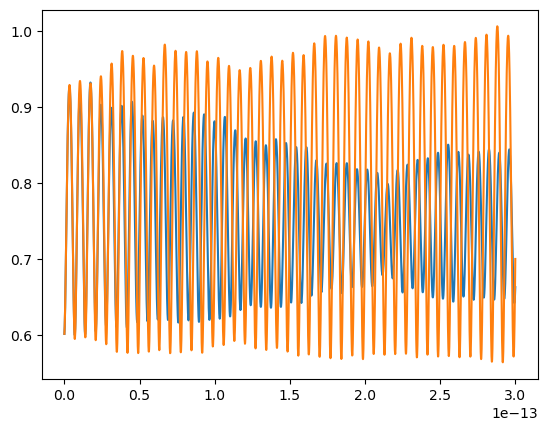

In [12]:
np_dist_full_3 = np.array(output_full_3[0])
np_dist_diag_3 = np.array(output_diag_3[0])

np.save('np_dist_full_delta=2',np_dist_full_3)
np.save('np_dist_diag_delta=2',np_dist_diag_3)

'''
np_dist_full_1 = np.array(output_full_1[0])
np_dist_diag_1 = np.array(output_diag_1[0])
np_dist_full_2 = output_full_2[0]
np_dist_diag_2 = output_diag_2[0]
'''

plt.plot(output_full_0[1],np_dist_full_3[1:,0]-np_dist_full_3[1:,1],label = 'full,2')
plt.plot(output_full_0[1],np_dist_diag_3[1:,0]-np_dist_diag_3[1:,1],label = 'diag,2')

'''
plt.plot(output_full_0[1],np_dist_full_1[1:,0]-np_dist_full_1[1:,1],label = 'full,0.2')
plt.plot(output_full_0[1],np_dist_diag_1[1:,0]-np_dist_diag_1[1:,1],label = 'diag,0.2')
plt.legend()
plt.show()
plt.plot(output_full_0[1],np_dist_full_2[:,0]-np_dist_full_2[:,1],label = 'full,0.5')
plt.plot(output_full_0[1],np_dist_diag_2[:,0]-np_dist_diag_2[:,1],label = 'full,0.5')
plt.plot(output_full_0[1],np_dist_full_3[:,0]-np_dist_full_3[:,1],label = 'full,1')
plt.plot(output_full_0[1],np_dist_diag_3[:,0]-np_dist_diag_3[:,1],label = 'full,1')
'''

In [17]:
np_temp_full_0 = np.array(output_full_0[3])
np_temp_diag_0 = np.array(output_diag_0[3])
np_temp_full_1 = np.array(output_full_1[3])
np_temp_diag_1 = np.array(output_diag_1[3])
np_temp_full_2 = np.array(output_full_2[3])
np_temp_diag_2 = np.array(output_diag_2[3])
np_temp_full_3 = np.array(output_full_3[3])
np_temp_diag_3 = np.array(output_diag_3[3])

np.save('np_dist_full_delta=10',np_temp_full_0)
np.save('np_dist_diag_delta=10',np_temp_diag_0)
np.save('np_dist_full_delta=5',np_temp_full_1)
np.save('np_dist_diag_delta=5',np_temp_diag_1)
np.save('np_dist_full_delta=15',np_temp_full_2)
np.save('np_dist_diag_delta=15',np_temp_diag_2)
np.save('np_dist_full_delta=2',np_temp_full_3)
np.save('np_dist_diag_delta=2',np_temp_diag_3)

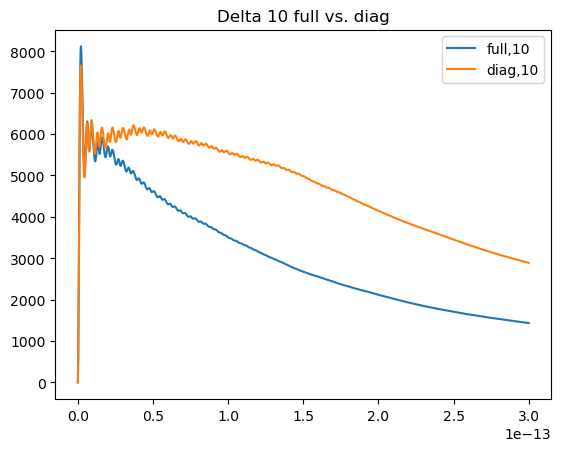

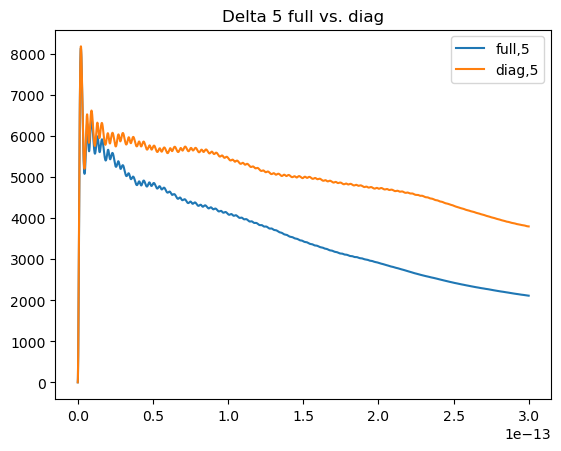

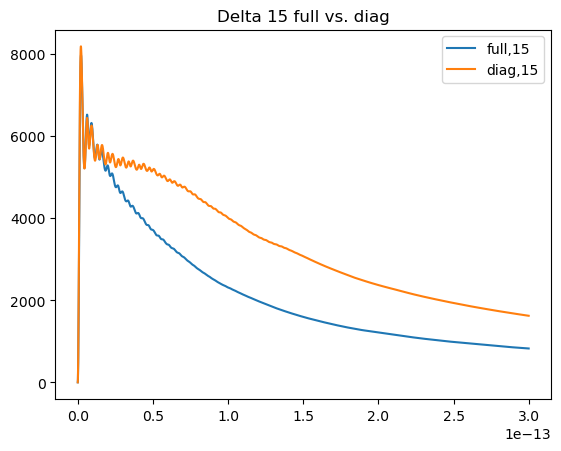

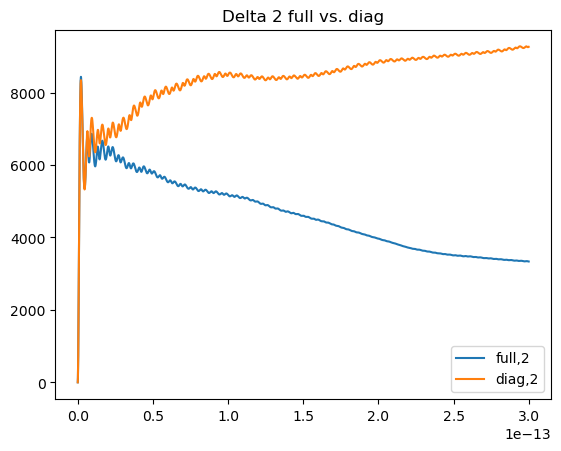

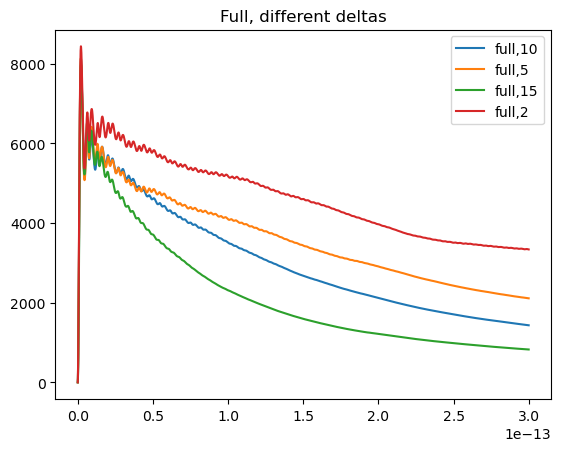

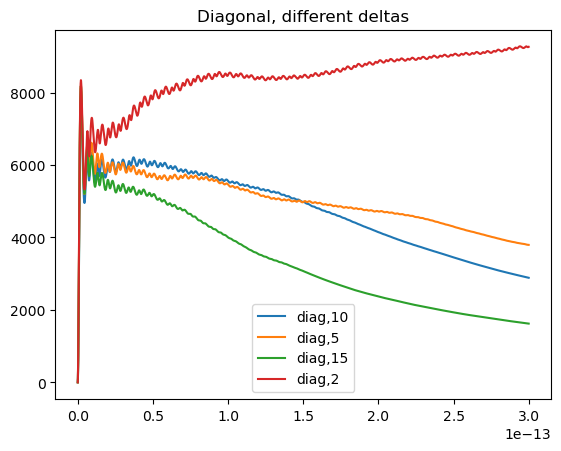

In [22]:
plt.title('Delta 10 full vs. diag')
plt.plot(output_full_0[1],np_temp_full_0,label = 'full,10')
plt.plot(output_full_0[1],np_temp_diag_0,label = 'diag,10')
plt.legend()
plt.show()

plt.title('Delta 5 full vs. diag')
plt.plot(output_full_0[1],np_temp_full_1,label = 'full,5')
plt.plot(output_full_0[1],np_temp_diag_1,label = 'diag,5')
plt.legend()
plt.show()

plt.title('Delta 15 full vs. diag')
plt.plot(output_full_0[1],np_temp_full_2,label = 'full,15')
plt.plot(output_full_0[1],np_temp_diag_2,label = 'diag,15')
plt.legend()
plt.show()

plt.title('Delta 2 full vs. diag')
plt.plot(output_full_0[1],np_temp_full_3,label = 'full,2')
plt.plot(output_full_0[1],np_temp_diag_3,label = 'diag,2')
plt.legend()
plt.show()

plt.title('Full, different deltas')
plt.plot(output_full_0[1],np_temp_full_0,label = 'full,10')
plt.plot(output_full_0[1],np_temp_full_1,label = 'full,5')
plt.plot(output_full_0[1],np_temp_full_2,label = 'full,15')
plt.plot(output_full_0[1],np_temp_full_3,label = 'full,2')
plt.legend()
plt.show()

plt.title('Diagonal, different deltas')
plt.plot(output_full_0[1],np_temp_diag_0,label = 'diag,10')
plt.plot(output_full_0[1],np_temp_diag_1,label = 'diag,5')
plt.plot(output_full_0[1],np_temp_diag_2,label = 'diag,15')
plt.plot(output_full_0[1],np_temp_diag_3,label = 'diag,2')
plt.legend()
plt.show()
